In [16]:
import numpy as np
import matplotlib.pyplot as plt
# scipy.io.loadmat is used for reading MATLAB mat files
from scipy.io import loadmat

# Importing specific functions from the py2d library
from py2d.spectra import energyTransfer_spectra, enstrophyTransfer_spectra
from py2d.apriori_analysis import energyTransfer, enstrophyTransfer, energyTransfer_domain_average, enstrophyTransfer_domain_average

# initialize_wavenumbers_rfft2: Initializes the wavenumbers for a 2D field
from py2d.initialize import initialize_wavenumbers_rfft2

# Omega2Psi: Converts vorticity to stream function in a 2D field
from py2d.convert import Omega2Psi, Psi2UV

from py2d.filter import filter2D

from py2d.SGSterms import Tau, PiUV, PiOmega, Sigma
from py2d.derivative import derivative

In [17]:
Lx, Ly = 2*np.pi, 2*np.pi
nx=1024
N_LES = 128
Delta = 2*Lx/N_LES

filter = 'gaussian'
coarseGrain = 'spectral'

dealias = True

filename = '../data/ICs/NX' + str(nx) + '/1.mat'

# Initialize the wave numbers
Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')
Kx_coarse, Ky_coarse, Kabs_coarse, Ksq_coarse, invKsq_coarse = initialize_wavenumbers_rfft2(N_LES, N_LES, Lx, Ly, INDEXING='ij')

# load the data from the file
data = loadmat(filename)
# get the Omega data from the file
Omega = data['Omega']

Psi = Omega2Psi(Omega, invKsq=invKsq)
U, V = Psi2UV(Psi, Kx, Ky)

# Calculating SGS terms
Tau11, Tau12, Tau22 = Tau(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)
Sigma1, Sigma2 = Sigma(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)
PiOmega_val = PiOmega(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)

# Filtering variables
U_f = filter2D(U, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
V_f = filter2D(V, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
Psi_f = filter2D(Psi, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
Omega_f = filter2D(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)



### Calculating Energy and Enstropy Transfer and their domain average

Energy transfer - Domain Average:  -0.0005716813160580331 -0.0005712280941826155
Enstrophy transfer - Domain Average:  0.8965262190462295 0.8981656998998961


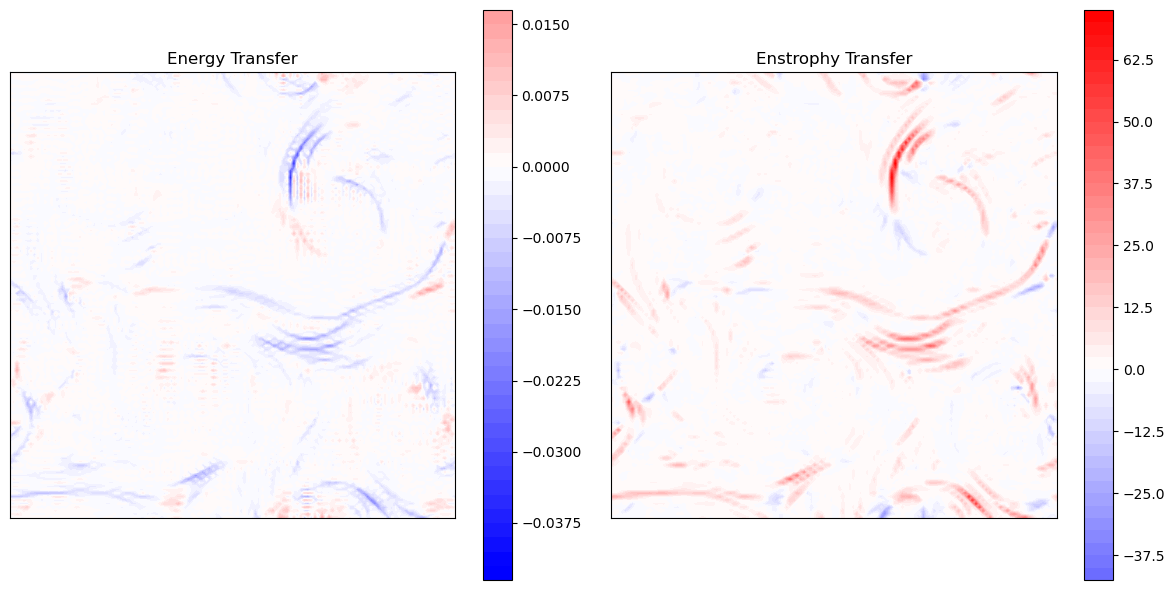

In [18]:
#  energy transfer 
energyTransfer_physical = energyTransfer(U_f, V_f, Tau11, Tau12, Tau22, Kx_coarse, Ky_coarse)
# enstrophy transfer
enstrophyTransfer_physical = enstrophyTransfer(Omega_f, Sigma1, Sigma2, Kx_coarse, Ky_coarse)

# Domain average

### Domain average of Energy transfer
# Method 1 - using Tau
energyTransfer_domainAvg_tau = np.mean(energyTransfer_physical) 
# Method 2 - using PiOmega
energyTransfer_domainAvg_PiOmega = energyTransfer_domain_average(Psi_f, PiOmega_val, dealias=dealias)


# Domain average of Enstrophy transfer
# Method 1 - using Sigma
enstrophyTransfer_domainAvg_Sigma = np.mean(enstrophyTransfer_physical)
# Method 2 - using PiOmega
enstrophyTransfer_domainAvg_PiOmega = enstrophyTransfer_domain_average(Omega_f, PiOmega_val, dealias=dealias)

print("Energy transfer - Domain Average: ", energyTransfer_domainAvg_tau, energyTransfer_domainAvg_PiOmega)
print("Enstrophy transfer - Domain Average: ", enstrophyTransfer_domainAvg_Sigma, enstrophyTransfer_domainAvg_PiOmega)


#### Contour of Energy transfer

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Energy Transfer
vmax_energy = np.max(np.abs(energyTransfer_physical))
vmin_energy = -vmax_energy

contour_energy = axs[0].contourf(energyTransfer_physical, cmap='bwr', levels=50, vmax=vmax_energy, vmin=vmin_energy)
cb = plt.colorbar(contour_energy, ax=axs[0])
axs[0].set_title('Energy Transfer')
axs[0].set_aspect('equal', 'box')  # Ensure equal box sizes
axs[0].set_xticks([])  # Remove x ticks
axs[0].set_yticks([])  # Remove y ticks

# Enstrophy Transfer
vmax_enstrophy = np.max(np.abs(enstrophyTransfer_physical))
vmin_enstrophy = -vmax_enstrophy

contour_enstrophy = axs[1].contourf(enstrophyTransfer_physical, cmap='bwr', levels=50, vmax=vmax_enstrophy, vmin=vmin_enstrophy)
cb = plt.colorbar(contour_enstrophy, ax=axs[1])
axs[1].set_title('Enstrophy Transfer')
axs[1].set_aspect('equal', 'box')  # Ensure equal box sizes
axs[1].set_xticks([])  # Remove x ticks
axs[1].set_yticks([])  # Remove y ticks

plt.tight_layout()
plt.show()


### Energy/Esntrophy Transfer Spectrum

(1, 64.0)

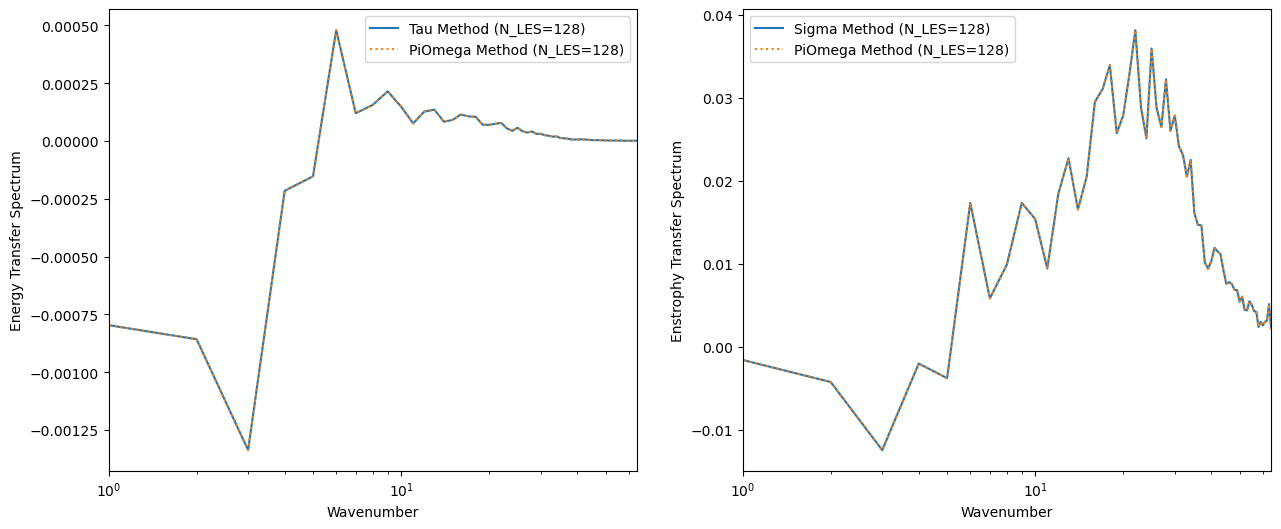

In [19]:
# Energy Transfer Spectra

# Method 1 - using Tau
energy_spectrumTau, k_energy_Tau = energyTransfer_spectra(U=U_f, V=V_f, Tau11=Tau11, Tau12=Tau12, Tau22=Tau22, Kx=Kx_coarse, Ky=Ky_coarse,method='Tau')
# Method 2 - using PiOmega
energy_spectrumPiOmega, k_energy_PiOmega = energyTransfer_spectra(Psi=Psi_f, PiOmega=PiOmega_val, Kx=Kx_coarse,Ky=Ky_coarse,method='PiOmega')

# Enstrophy Transfer Spectra

# Method 1 - using Sigma
enstrophy_spectrumSigma, k_enstrophy_Sigma = enstrophyTransfer_spectra(Omega=Omega_f, Sigma1=Sigma1, Sigma2=Sigma2, Kx=Kx_coarse, Ky=Ky_coarse,method='Sigma')
# Method 2 - using PiOmega
enstrophy_spectrumPiOmega, k_enstrophy_PiOmega = enstrophyTransfer_spectra(Omega=Omega_f, PiOmega=PiOmega_val, Kx=Kx_coarse, Ky=Ky_coarse,method='PiOmega')


# Plotting the energy / esntrophy tansfer spectra
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot energy transfer spectrum
axs[0].semilogx(k_energy_Tau, energy_spectrumTau, label=f'Tau Method (N_LES={N_LES})')
axs[0].semilogx(k_energy_PiOmega, energy_spectrumPiOmega, ':', label=f'PiOmega Method (N_LES={N_LES})')
axs[0].set_xlabel('Wavenumber')
axs[0].set_ylabel('Energy Transfer Spectrum')
axs[0].legend()
axs[0].set_xlim(1, (k_energy_Tau[-1]))


# Plot enstrophy transfer spectrum
axs[1].semilogx(k_enstrophy_Sigma, enstrophy_spectrumSigma, label=f'Sigma Method (N_LES={N_LES})')
axs[1].semilogx(k_enstrophy_PiOmega, enstrophy_spectrumPiOmega, ':', label=f'PiOmega Method (N_LES={N_LES})')
axs[1].set_xlabel('Wavenumber')
axs[1].set_ylabel('Enstrophy Transfer Spectrum')
axs[1].legend()
axs[1].set_xlim(1, (k_enstrophy_Sigma[-1]))

### Calculating and comparing energy/enstrophy transfer using dfferent methods

For N_LES: 512, filter: gaussian, coarseGrain: spectral
Energy Transfer from physical space Tau: -1.1423159975731346e-05
Energy Transfer from physical space PiOmega: -1.1422200150882657e-05
Integral of energy transfer spectrum Tau: -1.143676223913223e-05
Integral of energy transfer spectrum PiOmega: -1.1436732869832717e-05

energy Transfer from physical space (positive): 2.2641970617096274e-05
Integral of energy transfer spectrum Tau (positive): 0.00025967618332390773
Integral of energy transfer spectrum PiOmega (positive): 0.000259676212693266

energy Transfer from physical space (negative): -3.6777866188236246e-05
Integral of energy transfer spectrum Tau (negative): -0.00027111294556304003
Integral of energy transfer spectrum PiOmega (negative): -0.00027111294556309874

-------------------------------
Enstrophy Trnsfer from physical space: 0.36896834683458896
Enstrophy Trnsfer from physical space PiOmega: 0.36902013665788835
Integral of enstrophy Transfer spectrum Sigma: 0.3679630318

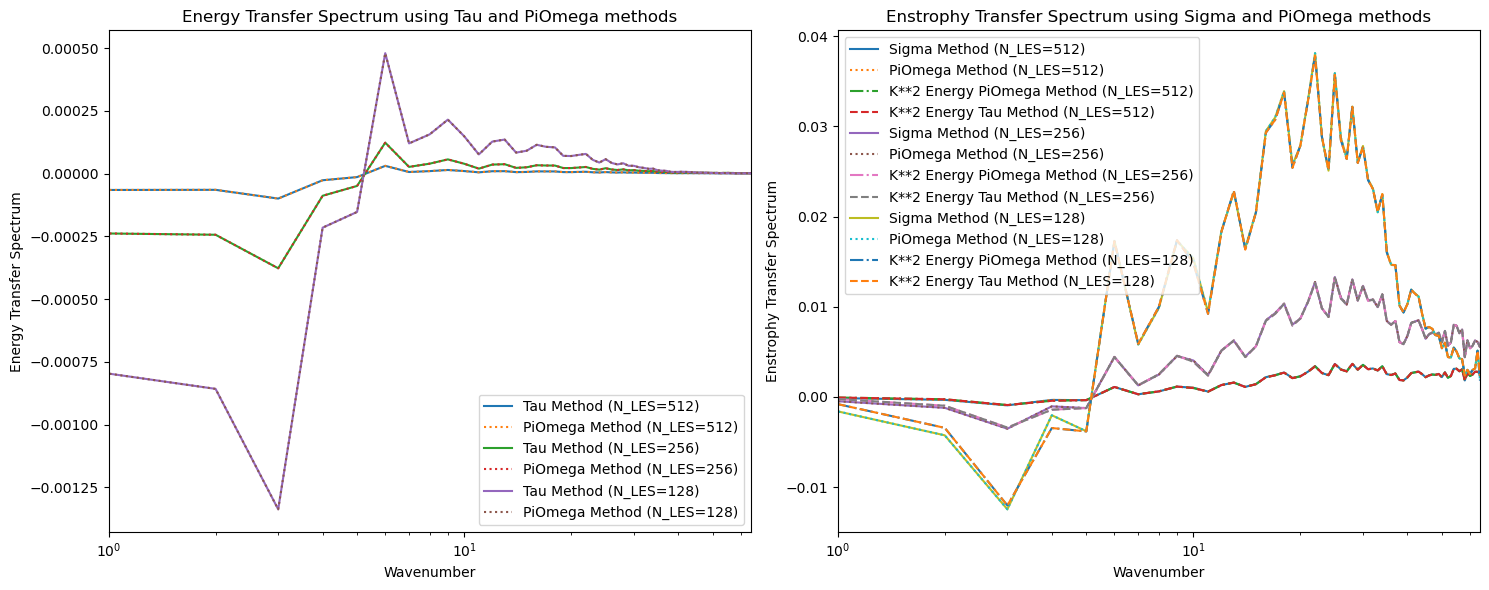

In [20]:
from py2d.SGSterms import Tau, PiUV, PiOmega, Sigma
from py2d.convert import Omega2Psi, Psi2UV, Tau2PiOmega
from py2d.spectra import energyTransfer_spectra, enstrophyTransfer_spectra
from py2d.derivative import derivative

# define the line styles to be used in the plots
line_styles = ['-', '--', ':']
# define the grid size of the domain for the calculations
N_LES_values = [512, 256, 128]



# Create a 2-panel figure
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

for idx, N_LES in enumerate(N_LES_values):

    Delta = 2*Lx/N_LES
    A = 1/Delta**2

    if coarseGrain == None:
        Kx_coarse, Ky_coarse, Kabs_coarse, Ksq_coarse, invKsq_coarse = initialize_wavenumbers_rfft2(nx, nx, Lx, Lx, INDEXING='ij')
    elif coarseGrain == 'spectral':
        Kx_coarse, Ky_coarse, Kabs_coarse, Ksq_coarse, invKsq_coarse = initialize_wavenumbers_rfft2(N_LES, N_LES, Lx, Lx, INDEXING='ij')

    # load the data from the file
    data = loadmat(filename)
    # get the Omega data from the file
    Omega = data['Omega']

    Psi = Omega2Psi(Omega, invKsq=invKsq)
    U, V = Psi2UV(Psi, Kx, Ky)

    Tau11, Tau12, Tau22 = Tau(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)
    Sigma1, Sigma2 = Sigma(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)
    PiOmegaa = PiOmega(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=np.ones(2, dtype=int)*N_LES, dealias=dealias)

    U_f = filter2D(U, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
    V_f = filter2D(V, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
    Psi_f = filter2D(Psi, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)
    Omega_f = filter2D(Omega, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, Ngrid=np.ones(2, dtype=int)*N_LES)

    # Compute energy and enstrophy spectra
    energy_spectrumTau, k_energy_Tau = energyTransfer_spectra(U=U_f, V=V_f, Tau11=Tau11, Tau12=Tau12, Tau22=Tau22, Kx=Kx_coarse, Ky=Ky_coarse,method='Tau')
    energy_spectrumPiOmega, k_energy_PiOmega = energyTransfer_spectra(Psi=Psi_f, PiOmega=PiOmegaa, Kx=Kx_coarse,Ky=Ky_coarse,method='PiOmega')

    enstrophy_spectrumSigma, k_enstrophy_Sigma = enstrophyTransfer_spectra(Omega=Omega_f, Sigma1=Sigma1, Sigma2=Sigma2, Kx=Kx_coarse, Ky=Ky_coarse,method='Sigma')
    # PiOmegaa = Tau2PiOmega(Tau11, Tau12, Tau22, Kx_coarse, Ky_coarse, spectral=False)
    enstrophy_spectrumPiOmega, k_enstrophy_PiOmega = enstrophyTransfer_spectra(Omega=Omega_f, PiOmega=PiOmegaa, Kx=Kx_coarse, Ky=Ky_coarse,method='PiOmega')

    # Plot energy transfer spectrum
    axs[0].semilogx(k_energy_Tau, energy_spectrumTau, label=f'Tau Method (N_LES={N_LES})')
    axs[0].semilogx(k_energy_PiOmega, energy_spectrumPiOmega, ':', label=f'PiOmega Method (N_LES={N_LES})')
    axs[0].set_xlabel('Wavenumber')
    axs[0].set_ylabel('Energy Transfer Spectrum')
    axs[0].legend()
    axs[0].set_title('Energy Transfer Spectrum using Tau and PiOmega methods')
    axs[0].set_xlim(1, (k_energy_Tau[-1]))
    # axs[0].grid(True, which="both", ls="--")
    # axs[0].set_ylim(1e-7, 1e-1)

    # Plot enstrophy transfer spectrum
    axs[1].semilogx(k_enstrophy_Sigma, enstrophy_spectrumSigma, label=f'Sigma Method (N_LES={N_LES})')
    axs[1].semilogx(k_enstrophy_PiOmega, enstrophy_spectrumPiOmega, ':', label=f'PiOmega Method (N_LES={N_LES})')
    axs[1].semilogx(k_enstrophy_PiOmega,(k_enstrophy_PiOmega**2)* energy_spectrumPiOmega, '-.', label=f'K**2 Energy PiOmega Method (N_LES={N_LES})')
    axs[1].semilogx(k_enstrophy_PiOmega,(k_enstrophy_PiOmega**2)* energy_spectrumTau, '--', label=f'K**2 Energy Tau Method (N_LES={N_LES})')
    axs[1].set_xlabel('Wavenumber')
    axs[1].set_ylabel('Enstrophy Transfer Spectrum')
    axs[1].legend()
    axs[1].set_title('Enstrophy Transfer Spectrum using Sigma and PiOmega methods')
    axs[1].set_xlim(1, (k_enstrophy_Sigma[-1]))
    # axs[1].grid(True, which="both", ls="--")
    # axs[1].set_ylim(1e-3, 1e0)

    enstrophyTransfer_physical = enstrophyTransfer(Omega_f, Sigma1, Sigma2, Kx_coarse, Ky_coarse)
    energyTransfer_physical = energyTransfer(U_f, V_f, Tau11, Tau12, Tau22, Kx_coarse, Ky_coarse)

    mean_energyTransfer_physical_PiOmega = energyTransfer_domain_average(Psi_f, PiOmegaa, dealias=dealias)
    mean_enstrophyTransfer_physical_PiOmega = enstrophyTransfer_domain_average(Omega_f, PiOmegaa, dealias=dealias)

    mean_enstrophyTransfer_physical = np.mean(enstrophyTransfer_physical)
    mean_energyTransfer_physical = np.mean(energyTransfer_physical)

    mean_pos_enstrophyTransfer_physical = np.mean(enstrophyTransfer_physical[enstrophyTransfer_physical>0])
    mean_pos_energyTransfer_physical= np.mean(energyTransfer_physical[energyTransfer_physical>0])

    mean_neg_enstrophyTransfer_physical = np.mean(enstrophyTransfer_physical[enstrophyTransfer_physical<0])
    mean_neg_energyTransfer_physical = np.mean(energyTransfer_physical[energyTransfer_physical<0])

    # scale_factor = 

    integral_energyTransfer_spectrumTau = np.sum(energy_spectrumTau)
    integral_energyTransfer_spectrumPiOmega = np.sum(energy_spectrumPiOmega)
    integral_enstrophyTransfer_spectrumSigma = np.sum(enstrophy_spectrumSigma)
    integral_enstrophyTransfer_spectrumPiOmega = np.sum(enstrophy_spectrumPiOmega)
    integral_Ksq_energyTransfer_spectrumTau = np.sum((k_energy_Tau**2)*energy_spectrumTau)
    integral_Ksq_energyTransfer_spectrumPiOmega = np.sum((k_energy_PiOmega**2)*energy_spectrumPiOmega)

    integral_pos_energyTransfer_spectrumTau = np.sum(energy_spectrumTau[energy_spectrumTau>0])
    integral_pos_energyTransfer_spectrumPiOmega = np.sum(energy_spectrumPiOmega[energy_spectrumPiOmega>0])
    integral_pos_enstrophyTransfer_spectrumSigma = np.sum(enstrophy_spectrumSigma[enstrophy_spectrumSigma>0])
    integral_pos_enstrophyTransfer_spectrumPiOmega = np.sum(enstrophy_spectrumPiOmega[enstrophy_spectrumPiOmega>0])

    integral_neg_energyTransfer_spectrumTau = np.sum(energy_spectrumTau[energy_spectrumTau<0])
    integral_neg_energyTransfer_spectrumPiOmega = np.sum(energy_spectrumPiOmega[energy_spectrumPiOmega<0])
    integral_neg_enstrophyTransfer_spectrumSigma = np.sum(enstrophy_spectrumSigma[enstrophy_spectrumSigma<0])
    integral_neg_enstrophyTransfer_spectrumPiOmega = np.sum(enstrophy_spectrumPiOmega[enstrophy_spectrumPiOmega<0])

    print(f"For N_LES: {N_LES}, filter: {filter}, coarseGrain: {coarseGrain}")

    print(f"Energy Transfer from physical space Tau: {mean_energyTransfer_physical}")
    print(f"Energy Transfer from physical space PiOmega: {mean_energyTransfer_physical_PiOmega}")
    print(f"Integral of energy transfer spectrum Tau: {integral_energyTransfer_spectrumTau}")
    print(f"Integral of energy transfer spectrum PiOmega: {integral_energyTransfer_spectrumPiOmega}\n")

    print(f"energy Transfer from physical space (positive): {mean_pos_energyTransfer_physical}")
    print(f"Integral of energy transfer spectrum Tau (positive): {integral_pos_energyTransfer_spectrumTau}")
    print(f"Integral of energy transfer spectrum PiOmega (positive): {integral_pos_energyTransfer_spectrumPiOmega}\n")

    print(f"energy Transfer from physical space (negative): {mean_neg_energyTransfer_physical}")
    print(f"Integral of energy transfer spectrum Tau (negative): {integral_neg_energyTransfer_spectrumTau}")
    print(f"Integral of energy transfer spectrum PiOmega (negative): {integral_neg_energyTransfer_spectrumPiOmega}\n")

    print("-------------------------------")

    print(f"Enstrophy Trnsfer from physical space: {mean_enstrophyTransfer_physical}")
    print(f"Enstrophy Trnsfer from physical space PiOmega: {mean_enstrophyTransfer_physical_PiOmega}")
    print(f"Integral of enstrophy Transfer spectrum Sigma: {integral_enstrophyTransfer_spectrumSigma}")
    print(f"Integral of enstrophy Transfer spectrum PiOmega: {integral_enstrophyTransfer_spectrumPiOmega}\n")
    print(f"Integral of k**2 energy Transfer spectrum Tau: {integral_Ksq_energyTransfer_spectrumTau}")
    print(f"Integral of k**2 energy Transfer spectrum PiOmega: {integral_Ksq_energyTransfer_spectrumPiOmega}\n")

    print(f"Enstrophy Trnsfer from physical space (positive): {mean_pos_enstrophyTransfer_physical}")
    print(f"Integral of enstrophy Transfer spectrum Sigma (positive): {integral_pos_enstrophyTransfer_spectrumSigma}")
    print(f"Integral of enstrophy Transfer spectrum PiOmega (positive): {integral_pos_enstrophyTransfer_spectrumPiOmega}\n")

    print(f"Enstrophy Trnsfer from physical space (negative): {mean_neg_enstrophyTransfer_physical}")
    print(f"Integral of enstrophy Transfer spectrum Sigma (negative): {integral_neg_enstrophyTransfer_spectrumSigma}")
    print(f"Integral of enstrophy Transfer spectrum PiOmega (negative): {integral_neg_enstrophyTransfer_spectrumPiOmega}\n")

    print("-------------------------------")


plt.tight_layout()
plt.show()